# **Práctica: Monitorización de rendimiento del servidor con Python**

### **Objetivo de la Práctica**

En esta práctica aplicaremos los conocimientos de conexión, modelado de datos (Point) y escritura eficiente en lote (Batching) para crear un agente de monitorización que envíe métricas de un sistema operativo a InfluxDB.

## **PARTE I: Obtención de métricas**

Para esta práctica, utilizaremos la librería psutil para obtener las métricas de rendimiento de la máquina en la que se ejecuta el script.

In [8]:
import psutil
import time

# Obtener estadísticas de uso
def obtener_metricas_sistema(host_id):
    # Uso de CPU (promedio de los últimos segundos)
    cpu_usage = psutil.cpu_percent(interval=1)
    
    # Uso de RAM
    mem = psutil.virtual_memory()
    ram_used_gb = round(mem.used / (1024**3), 2) # Conversión a GB
    ram_percent = mem.percent
    
    # Uso de disco (en el punto de montaje raíz)
    disk = psutil.disk_usage('/')
    disk_percent = disk.percent
    
    return {
        'host': host_id,
        'cpu_percent': cpu_usage,
        'ram_used_gb': ram_used_gb,
        'ram_percent': ram_percent,
        'disk_percent': disk_percent
    }

# Ejemplo de uso:
# metrics = obtener_metricas_sistema("servidor_01")
# print(metrics)

## **PARTE II: Modelado y escritura en lote**

1. **Diseño del modelo InfluxDB**

El modelo debe asegurar que las métricas sean fáciles de consultar por máquina (host).

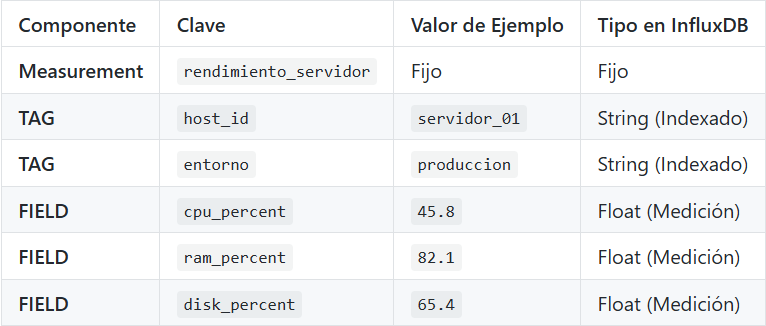

2. **Tareas de Implementación**

Desarrolla el script Python principal ``(agente_monitoreo.py)`` para:

1. **Inicialización:** configurar el cliente y la ``WriteAPI`` en **modo Batching** (asíncrono) para optimizar el rendimiento.
2. **Bucle de lectura:** crear un bucle infinito que:
- a. Llame a ``obtener_metricas_sistema("servidor_A")`` **cada segundo**.
- b. Construya un nuevo objeto Point por cada lectura, respetando el modelo de datos anterior.
- c. Use la ``write_api.write()`` para enviar el punto al buffer.
3. **Cierre:** Asegurarse de que el script llama a ``write_api.close()`` antes de salir (p.ej., en una excepción de teclado) para vaciar cualquier punto que quede en el buffer.

In [31]:
def agente_monitoreo():
    import influxdb_client
    from influxdb_client.client.write_api import ASYNCHRONOUS, WriteOptions
    from influxdb_client.client.exceptions import InfluxDBError
    from urllib3.exceptions import NewConnectionError

    INFLUX_URL = "http://influxdb2:8086"
    INFLUX_TOKEN = "MyInitialAdminToken0="

    print("--- Iniciando conexión a InfluxDB ---")

    client = None
    write_api = None
    try:
        client = influxdb_client.InfluxDBClient(
            url=INFLUX_URL,
            token=INFLUX_TOKEN,
            org="dev_pruebas"
        )

        print(f"Verificando estado de salud de InfluxDB en {INFLUX_URL}...")
        health = client.health()
    
        if health.status == "pass":
            print("[INFO] ¡Conexión exitosa!")
            print(f"[INFO] Versión del servidor: {health.version}")
        else:
            print(f"[ERROR] Conexión fallida. Estado: {health.status}")
            print(f"[INFO] Mensaje: {health.message}")

        
        write_options = WriteOptions(
            batch_size=500,
            flush_interval=1000,
            write_type=ASYNCHRONOUS
        )
 
        write_api = client.write_api(write_options=write_options)
        
        from influxdb_client import Point
        while True:
            metricas = obtener_metricas_sistema("servidor_A")  # Aquí debes definir esta función
            punto = (
                Point("rendimiento_servidor")
                .tag("host_id", "servidor_A")
                .tag("entorno", "PRODUCCION")
                .field("cpu", metricas["cpu_percent"])
                .field("ram", metricas["ram_percent"])
                .field("disk", metricas["disk_percent"])
            )
            print(metricas)
            write_api.write(bucket="prueba1", org="docs", record=punto)

    except KeyboardInterrupt:
        print("Cerrado")
    
    finally:
       
        if write_api:
            write_api.close()
            print("write_api cerrado")

In [32]:
agente_monitoreo()

--- Iniciando conexión a InfluxDB ---
Verificando estado de salud de InfluxDB en http://influxdb2:8086...
[INFO] ¡Conexión exitosa!
[INFO] Versión del servidor: v2.7.12
{'host': 'servidor_A', 'cpu_percent': 4.6, 'ram_used_gb': 2.57, 'ram_percent': 76.6, 'disk_percent': 3.4}
Cerrado
write_api cerrado
